# Sistemas Inteligentes

## Exercício Computacional 4 - Agrupamento (Clusterização)

### Identificação do Aluno

#### Nome Completo

João Pedro Poloni Ponce

#### RA

11116513

## Instruções

1. Escolha um dataset, identifique-o e mostre suas características, então indique quais são os seus objetivos com esse dataset (no campo correspondente).

2. Com o dataset já importado para o notebook, faça os pré-processamentos que julgar necessários e, se for conveniente, efetue uma redução de dimensionalidade utilizando um método compatível com seus dados.

3. Utilize ao menos um método de Cross-Validation de sua preferência.

4. Escolha dois métodos de agrupamento (clusterização) para realizar abordagens distintas, então aplique-os ao dataset para chegar ao objetivo indicado por você no próprio notebook.

5. Utilize células intermediárias de tipo _Markdown_ para explicar o que é feito em cada célula de código. Mas não deixe de utilizar comentários breves e pertinentes dentro do próprio código. Isto significa que o desenvolvimento NÃO deve ser feito em uma única célula.

6. Sempre que for cabível, exiba as figuras, os gráficos, os valores (ao menos parte deles) etc., mas procure sempre manter um capricho em todas as saídas.

7. Ao final, comente da forma mais completa possível os resultados obtidos, sempre sugerindo o que poderia ser feito para melhorá-los e fornecendo elementos que contribuam para a sua compreensão.

8. Respeitem as regras gramaticais e procurem manter coesão, coerência e fluidez em seus textos.

9. Apesar de a análise dos resultados ser mais importante do que o código em si, serão analisados critérios como organização e clareza do código, então evitem códigos "poluídos" e confusos.

### Dataset

#### Nome do Dataset

Rijksmuseum API Dataset

#### Características do Dataset

Dataset obtido via API disponibilizada pelo Museu Rijksmuseum, internacionalmente famoso por possuir a mais vasta coleção
dos mentre Holandeses em seu acervo. O dataset é composto por imagens das obras de arte contidas em seu acervo, bem como o título da obra, o nome do artista e ano de produção. A API fornecidade pelo museu possui uma série de parâmetros que se utilizadas podem retornar outros dados além dos já mencionados, porém para este experimento foi utilizada apenas uma imagem para estudar a distribuição de cores na obra retornada pela API.

#### Fonte do Dataset

[Rijksmuseum API](https://www.rijksmuseum.nl/en/api) - Página do museu explicando sobre o funcionamento da API.
<br>
[Documentação Rijksmuseum API](http://rijksmuseum.github.io/) - Página da documentaçao da API no GitHub, explicando o funcionamento de cada parâmetro.

### Objetivos

Estudar a distribuição de cores presentes numa determinda obra através da clusterização dos pixel contidos na mesma, para isso será utilizadas os procedimentos necessários para adequar o dataset para que o algoritmo Kmeans e o Afinity Propagation efetue a clusterização na quantidade de cores que o usuário desejar.

## Desenvolvimento

### Construindo o Dataset apartir da API
O museu Rijksmuseum disponibiliza os quadros de seu acervo via API, que retornam um JSON contendo o link para a imagem, ou seja, ele não possui um dataset no formato necessário para que as ferramentas adequadas possam ser utilizadas.

#### Importando as bilbiotecas necessarias
Aqui é feita a importação das bibliotecas necessárias para que seja possível requisitar a obra, manipular e clusterizar a imagem retornada via API.

In [118]:
import numpy as np
import requests # Biblioteca necessária para requisitar a API do Rijksmuseum
from PIL import Image
from io import BytesIO
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

from skimage.transform import rescale, resize, downscale_local_mean

#### Pegando as Imgens do Museu
Como as imagens das obras do Rijksmuseum são disponibilizadas via API, é ncessário fazer uma chamada HTTP para o endereço disponibilizado na documentação, bem como a utilização correta dos parâmetros fornecidos, para este projeto foram utlizados os seguintes:
- en -> para retorno dos dados seja em ingles
- collection -> informa que requisitamos os dados da coleção do Rijkmuseum
- key -> chave de API obtida via cadastro no site do museu(link fonecidos no intem fonte do dataset
- format -> formato de retorno dos dados, no caso, o mais agradável dentre os diponíveis era o json
- p -> numero de resultados retornados
- ps -> resultados retorndos por página

A requisição dos dados podiam ser feitas de inúmeras formas diferentes, como por exemplo utilizar a biblioteca nativa do Python urllib3, porém como a blioteca requests está instalada ela foi utlizda devido a sua facilidade de uso.
<br><br>
*ps*: Professor vou disponibilizar essa chave de API até o final do quadrismestre, caso for necessário mais tempo para a correção do execócio me avise que matenho ela ativa ou gero uma nova.

Sobre a obra:   The Art Gallery of Jan Gildemeester Jansz, Adriaan de Lelie, 1794 - 1795
Link para a imagem:  https://lh3.googleusercontent.com/vkoS9jmZLZWuWH1LNIG3eJUVI6W7XqOUKmFf_lcuB4m1nJydWPXZGggi3XGwmirNj1wLdiO7sH6x5fJ60XJnH2expg


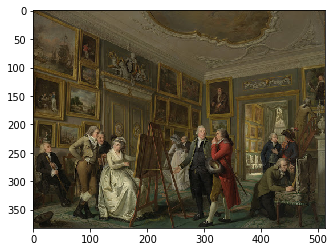

In [139]:
data = requests.get('https://www.rijksmuseum.nl/api/en/collection?key=2DgaQ8AI&format=json&p=5&ps=5')
data = data.json()

imagem_original = requests.get(data['artObjects'][4]['webImage']['url'])
imagem = np.array(Image.open(BytesIO(imagem_original.content)))

print("Sobre a obra: ", data['artObjects'][4]['longTitle'])
print("Link para a imagem: ", data['artObjects'][4]['webImage']['url'])
plt.imshow(imagem)


#### Gerando o dataset
Aqui o dataset é gerado. A imagem obtida via API é adequada para ser utilizada no sklearn através do uso da biblioteca de manpulação numérica numpy.

In [120]:
dataset = np.array(imagem)
w = dataset.shape[0]
h = dataset.shape[1]

print(dataset.shape)

(382, 512, 3)


#### Redução de Dimensionalidade
Faz se necessário a redução da dimensionalidade do dataset, pois originalmente ele possui três dimensões, algo que os algortimos de clusterização como Kmeans e Afinity Propagation suportam apenas duas. Para adequalos aos algoritmos foi multiplacado a largura pela altura, colocando o pixel em função da posição dele no array.

In [121]:
museum = dataset.reshape(dataset.shape[0]*dataset.shape[1], -1)
print(museum.shape)

(195584, 3)


#### Clusterização KMeans
Aqui é selecionado o número de cores que se deseja clusterizar por meio da variável ```n_cores```. É usado shuffle para fazer a validação cruzada do conjunto de cores disponiveis na obra, ou seja, é através dessa biblioteca em que os pontos sejam embaralhados o suficiente para que o resultado seja válido. Aqui também é aplicado o algoritmo kmeans para clusterizar os dados embarelhados pelo shuffle.

In [122]:
n_cores = 5
X_shuffle = shuffle(museum)
kmeans_shuffle = KMeans(n_clusters=n_cores, random_state=0).fit(X_shuffle)

#### Prevendo os dados
Neste momento é feito a predição dos dados embaralhandos previamente e o resultado é armazenado na variável ```grupos```, ou seja, com base no modelo criado pelo kmeans na célula anterior é possível prever o resultado de um dado conjunto.

In [124]:
grupos = kmeans_shuffle.predict(X_shuffle)
print(grupos.shape)

(195584,)


#### Resultado KMeans
Aqui é possível visualizar o resultado obtido num grafico contendo a distribuição de cores de uma determinda obra de arte.

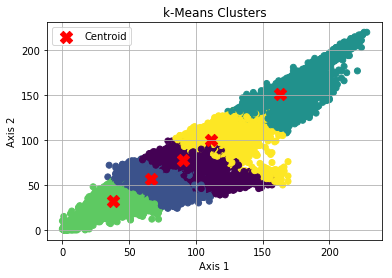

In [125]:
plt.figure()
plt.scatter(x=X_shuffle[:, 0], y=X_shuffle[:, 1], c=grupos)
plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.title('k-Means Clusters')
plt.grid(True)

plt.scatter(x=kmeans_shuffle.cluster_centers_[:,0], y=kmeans_shuffle.cluster_centers_[:,1], c='r', s=150, marker='X', label='Centroid')
plt.legend()

#### Clusterização Afinity Propagation
É usado shuffle para fazer a validação cruzada do conjunto de cores disponiveis na obra, ou seja, é através dessa biblioteca em que os pontos sejam embaralhados o suficiente para que o resultado seja válido. Aqui também é aplicado o algoritmo Affinity Propagation para clusterizar os dados embarelhados pelo shuffle.

In [133]:
X_shuffle_AP = shuffle(museum, n_samples=50)
AP = AffinityPropagation().fit(X_shuffle_AP)

#### Prevendo os dados
Neste momento é feito a predição dos dados embaralhandos previamente e o resultado é armazenado na variável ```grupos_AP```, ou seja, com base no modelo criado pelo Affinity Propagation na célula anterior é possível prever o resultado de um dado conjunto.

In [134]:
grupos_AP = AP.predict(X_shuffle)
print(grupos_AP.shape)

(195584,)


#### Resultado AffinityPropagation
Aqui é possível visualizar o resultado obtido num grafico contendo a distribuição de cores de uma determinda obra de arte.

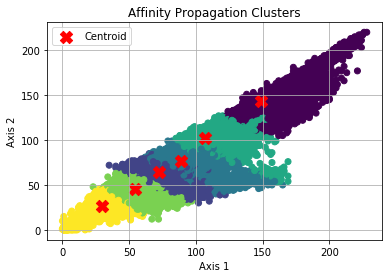

In [136]:
plt.figure()
plt.scatter(x=X_shuffle[:, 0], y=X_shuffle[:, 1], c=grupos_AP)
plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.title('Affinity Propagation Clusters')
plt.grid(True)

plt.scatter(x=AP.cluster_centers_[:,0], y=AP.cluster_centers_[:,1], c='r', s=150, marker='X', label='Centroid')
plt.legend()

## Discussão sobre os resultados

Ao final do experimento foram gerados dois gráficos, um referente ao uso do algoritmo KMeans e outro ao AffinityPropagation, eles possuem um certo grau similaridade mas também possuem diferenças, pois, apesar de ambos mêtodos clusterizarem uma determinda amostra eles fazem isso por meios diferentes.

Em relação a similaridade de amobos os gráficos, a mancha de cores representa os dados agrupados em seus respectivos clusters, é interessante notar que apesar do uso de diferentes mêtodos de clusterização o formato da mancha se mantém pois os dados são os mesmos, logo a repetição do formato era esperada.

No caso da aplicação do algoritmo KMeans, foi formado cinco clusters, ou seja, foi gerado um modelo de predição que a partir de um entrada de dados iria agrupá-los em cinco casos possíveis. De acordo com o gráfico gerado, é possível notar que cinco cores foram suficientes para dividir o espaço, porem há pontos, principalmente na mancha azul e roxa, que invadem a mancha subsequente, estão até proximo do centro da medida para o algoritmo, tal informação revela que cinco cores não foram suficiente para uma representação real do espaço.

A insuficiência fica mais clara ao comparar com o quadro utilizado. A riqueza de detalhes que a obra possui, com vários elementos em foco no quadro que possuem várias cores, logo é provavel que a utilização de mais clusters possa melhorar o desempenho do algoritmo KMeans, porém é preciso enfatizar que dados os cinco clusters o algoritmo kmeans consegui dividir bem o espaço só por alguns detalhes não o representou muito bem.

Com relação ao algoritmo AffinityPropagation, este último produziu resultados mais interessante pois nele não é possível determinar a quantidade de clusters desejados ao inves disso ele clusteriza com base na amostra fornecida, basicamente quanto maior a amostra melhores serão os resultados, o que pode ser um problema computacionalmente pois não existem recursos infinitos. Para o experimento em questão foram o AffinityPropagation utilizou 100 amostras selecionadas aleatóriamente pelo método ```shuffle```, e sómente com essa quantidade ele agrupou os dados em seis clusters, um a mais que o kmeans, e dessa vez apenas a mancha roxa teve pontos significativos no mancha subsequente, o que mais uma vez mostra que a quantidade de cluster não foi suficiente para representar bem o espaço, porém seu desempenho foi superior ao KMeans.

Tal estudo revela que a distribuição de cores num obra de arte não é algo simple de ser estudado pois tudo depende do quão detalhado é a obra e quão variada é a paleta de cores. Para a obra em questão, rica em detalhes e cores, não é tão simples agrupar as cores em poucos clusters ou com poucas amostras como foi utilizado neste experimento, mas produziu resultados interessantes, uma vez que ambos os algoritmos conseguiram dividir bem o espaço, agrupando todos os pontos dentro dos cluster disponiveis, seja pela proximidade do centro do cluster ou maior afinidade.

![Obra analisada](https://lh3.googleusercontent.com/vkoS9jmZLZWuWH1LNIG3eJUVI6W7XqOUKmFf_lcuB4m1nJydWPXZGggi3XGwmirNj1wLdiO7sH6x5fJ60XJnH2expg)
<p style="text-align: center;">The Art Gallery of Jan Gildemeester Jansz, Adriaan de Lelie, 1794 - 1795</p